In [1]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0
      /_/

Using Python version 3.5.5 (default, Mar 12 2018 16:25:05)
SparkSession available as 'spark'.


### Load data

In [2]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
df = spark.read.csv('../data/df_model_final.csv', header=True, inferSchema=True).cache()
df

DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, device_type: int, #song_play_80pct_last_1: int, #song_play_80pct_last_3: int, #song_play_80pct_last_7: int, #song_play_80pct_last_14: int, #song_play_80pct_last_30: int]

In [4]:
df.show(2)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------------------+-----------------------+-----------------------+------------------------+------------------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|device_type|#song_play_80pct_last_1|#song_play_80pct_last_3|#song_play_80pct_last_7|#song_play_80pct_last_14|#song_play_80pct_last_30|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+-------------------

### Prepare training data

In [5]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 '#song_play_80pct_last_1',
 '#song_play_80pct_last_3',
 '#song_play_80pct_last_7',
 '#song_play_80pct_last_14',
 '#song_play_80pct_last_30']

In [6]:
# prepare data
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
data = assembler.transform(df)
data

DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, device_type: int, #song_play_80pct_last_1: int, #song_play_80pct_last_3: int, #song_play_80pct_last_7: int, #song_play_80pct_last_14: int, #song_play_80pct_last_30: int, features: vector]

In [7]:
# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

### Fit logistic regression

In [8]:
ml = LogisticRegression(maxIter=3, regParam=0.01)
model = ml.fit(train)

### Predict and Evaluate performance

In [9]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()


+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.93664801529136...|       0.0|    0|(20,[2,3,4,17,18,...|
|[0.40613318812373...|       1.0|    0|(20,[1,2,3,4,11,1...|
|[0.24939890838509...|       1.0|    1|(20,[3,4,18,19],[...|
|[0.82328573381778...|       0.0|    0|(20,[1,2,3,4,9,14...|
|[0.25321609481450...|       1.0|    1|(20,[4,19],[24.0,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.26346626147596...|       1.0|    1|(20,[3,4,13,14,18...|
|[0.28246377123545...|       1.0|    1|(20,[2,3,4,14,17,...|
|[0.93329148570641...|       0.0|    0|[6.0,6.0,6.0,27.0...|
|[0.70227865724527...|       0.0|    1|(20,[3,4,9,12,13,...|

### Evaluate performance

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show() 

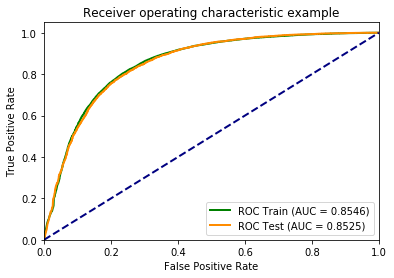

In [11]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Let's train random forest too!

In [12]:
ml = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,numTrees=50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=12 #20
                            ,minInstancesPerNode=10
                            ,maxBins=16
                            )
model = ml.fit(train)

In [13]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.43591661456382...|       1.0|    0|(20,[2,3,4,17,18,...|
|[0.90975564697654...|       0.0|    0|(20,[1,2,3,4,11,1...|
|[0.20042914003498...|       1.0|    1|(20,[3,4,18,19],[...|
|[0.88303186577469...|       0.0|    0|(20,[1,2,3,4,9,14...|
|[0.07604977148124...|       1.0|    1|(20,[4,19],[24.0,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.46344741783660...|       1.0|    1|(20,[3,4,13,14,18...|
|[0.64677486201482...|       0.0|    1|(20,[2,3,4,14,17,...|
|[0.80484301743821...|       0.0|    0|[6.0,6.0,6.0,27.0...|
|[0.64960286285768...|       0.0|    1|(20,[3,4,9,12,13,...|

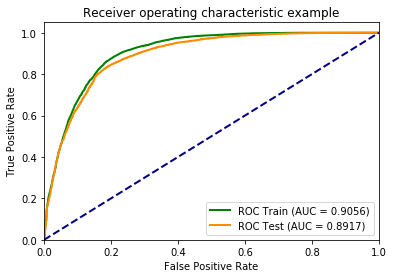

In [14]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)